# Blind Docking

In [1]:
from pymol import cmd
import py3Dmol

from vina import Vina

import pandas as pd
import numpy as np

from openbabel import pybel

from rdkit import Chem
from rdkit.Chem import AllChem,rdFMCS, Draw

from meeko import MoleculePreparation
from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

import prolif as plf
from prolif.plotting.network import LigNetwork


import sys, os, random, time
sys.path.insert(1, 'utilities/')

from multiprocessing import Pool

from utils import fix_protein, getbox, generate_ledock_file, dok_to_sdf

import warnings
warnings.filterwarnings("ignore")

%config Completer.use_jedi = False

### Setting the working directory

In [2]:
os.chdir('test/Blind_Docking/')

### Loading the system from PDB

In [3]:
cmd.fetch(code='1XOZ',type='pdb1')
cmd.select(name='Prot',selection='polymer.protein')
cmd.select(name='Lig',selection='organic')
cmd.save(filename='1XOZ_clean.pdb',format='pdb',selection='Prot')
cmd.save(filename='1XOZ_lig.mol2',format='mol2',selection='Lig')
cmd.delete('all')

 PyMOL not running, entering library mode (experimental)


### Protein sanitization

In [4]:
fix_protein(filename='1XOZ_clean.pdb',addHs_pH=7.4,try_renumberResidues=True,output='1XOZ_clean_H.pdb')

### Ligand sanitization

RDKit WARNING: [19:39:52] 1XOZ: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.
RDKit ERROR: [19:39:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit ERROR: 


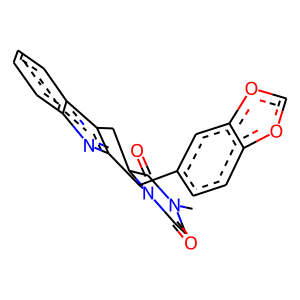

In [5]:
m=Chem.MolFromMol2File('1XOZ_lig.mol2',False)
Draw.MolToImage(m)

In [6]:
mol= [m for m in pybel.readfile(filename='1XOZ_lig.mol2',format='mol2')][0]
mol.addh()
out=pybel.Outputfile(filename='1XOZ_lig_H.mol2',format='mol2',overwrite=True)
out.write(mol)
out.close()

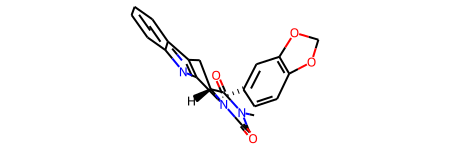

In [7]:
m=Chem.MolFromMol2File('1XOZ_lig_H.mol2')
m

### System visualization

In [8]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1XOZ_clean_H.pdb','r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

view.addModel(open('1XOZ_lig_H.mol2','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Molecular docking

### Protein preparation

In [9]:
!../../bin/prepare_receptor -v -r 1XOZ_clean_H.pdb -A hydrogens -o 1XOZ_clean_H.pdbqt

set verbose to  True
set receptor_filename to  1XOZ_clean_H.pdb
set repairs to  hydrogens
set outputfilename to  1XOZ_clean_H.pdbqt
read  1XOZ_clean_H.pdb
setting up RPO with mode= automatic and outputfilename=  1XOZ_clean_H.pdbqt
charges_to_add= gasteiger
delete_single_nonstd_residues= None
adding gasteiger charges to peptide
Sorry, there are no Gasteiger parameters available for atom 1XOZ_clean_H:A:GLU326:OXT


### Ligand preparation

#### Method 2: pybel

In [10]:
ligand = [m for m in pybel.readfile(filename='1XOZ_lig_H.mol2',format='mol2')][0]
out=pybel.Outputfile(filename='1XOZ_lig_H.pdbqt',format='pdbqt',overwrite=True)
ligand.addh()
out.write(ligand)
out.close()

### Protein pockets identification

In [11]:
!../../bin/fpocket -f 1XOZ_clean_H.pdb -d > pocket_descriptors.csv

In [12]:
descriptors_data=pd.read_csv('pocket_descriptors.csv',sep=' ',index_col=[0])
descriptors_data

drug_score     volume  nb_asph  inter_chain  apol_asph_proportion  \
cav_id                                                                      
1           0.8741  1032.9178      139            0                0.6331   
2           0.0452   576.4701       72            0                0.3333   
3           0.0003   488.8109       37            0                0.3243   
4           0.0021   384.3039       30            0                0.4667   
5           0.0009   109.8774       23            0                0.3913   
6           0.0046   230.1665       34            0                0.4706   
7           0.0005   222.8481       16            0                0.6250   
8           0.0004   217.8708       15            0                0.2667   
9           0.0012   267.7232       33            0                0.6061   
10          0.0030   629.4237       52            0                0.2500   
11          0.0017   195.3579       26            0                0.6538   
12          0.0014  1090.2328      107            0                0.3645   
13          0.0009   360.7762       33            0                0.5758   
14          0.0002   310.3074       22            0                0.1818   
15          0.0003   410.7528       34            0                0.3529   
16          0.0001   298.5970       16            0                0.1875   
17          0.0012   203.9857       20            0                0.7500   
18          0.0008   334.5363       16            0                0.4375   
19          0.0001   279.3722       16            0                0.3750   
20          0.0000   247.1797       17            0                0.0588   
21          0.0002   302.7696       22            0                0.1364   
22          0.0004   411.6484       24            0                0.2917   

        mean_asph_radius  as_density  mean_asph_solv_acc  mean_loc_hyd_dens  \
cav_id                                                                        
1                 4.0200      6.8663              0.4647            60.2955   
2                 3.7437      5.5621              0.4716            19.5833   
3                 4.0605      5.1642              0.5894            10.6667   
4                 3.9872      4.2452              0.6120            11.7143   
5                 3.5100      2.0155              0.3504             8.0000   
6                 3.8398      3.2787              0.4623            15.0000   
7                 3.9238      2.4631              0.6783             9.0000   
8                 3.9367      2.9664              0.5179             3.0000   
9                 4.1402      2.1593              0.6400            19.0000   
10                3.8994      5.4225              0.5173            10.1538   
11                3.7947      2.5979              0.6718            16.0000   
12                3.9622      8.3226              0.5096            21.0769   
13                3.8339      3.4003              0.4685            18.0000   
14                3.6869      2.9155              0.3809             3.0000   
15                3.9346      3.8391              0.5044            10.3333   
16                3.8434      2.9985              0.5507             2.0000   
17                3.8541      1.6062              0.4941            14.0000   
18                3.8732      3.4750              0.4447             6.0000   
19                3.9213      2.6588              0.6055             5.0000   
20                3.9535      2.8521              0.5774             0.0000   
21                3.8877      2.4383              0.4918             2.0000   
22                4.1979      3.5434              0.5977             6.0000   

        flex  ...  val  trp  tyr  chain_1_type  chain_2_type  num_res_chain_1  \
cav_id        ...                                                               
1        0.0  ...    0    1    2             0             0              325   
2        0.0  ...  

### Pockets visualization

In [13]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1XOZ_clean_H.pdb','r').read(),'pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
#view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('1XOZ_lig_H.mol2','r').read(),'mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.1}})


for file in os.listdir(path='1XOZ_clean_H_out/'):
    if '.pqr' in file:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        view.addModel(open('1XOZ_clean_H_out/'+file,'r').read(),'pqr')
        x = view.getModel()
        x.setStyle({},{'sphere':{'color':color[0],'opacity':0.6}}) 
        
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Per-pocket docking box set up (vina)

Hint: You may think about extending the pocket box by 4-5 armostrongs ...

In [14]:
for file in os.listdir('1XOZ_clean_H_out/'):
    if 'pqr' in file:
        pocket_num=int(file.split('_')[0].replace('pocket',''))
        cmd.load(filename='1XOZ_clean_H_out/'+file,format='pqr',object=pocket_num)
        
        center,size=getbox(selection=pocket_num,extending=5.0,software='vina')
        
        descriptors_data.loc[pocket_num,'center_x']=center['center_x']
        descriptors_data.loc[pocket_num,'center_y']=center['center_y']
        descriptors_data.loc[pocket_num,'center_z']=center['center_z']
        
        descriptors_data.loc[pocket_num,'size_x']=size['size_x']
        descriptors_data.loc[pocket_num,'size_y']=size['size_y']
        descriptors_data.loc[pocket_num,'size_z']=size['size_z']
        
        cmd.delete('all')

In [15]:
descriptors_data.head(10)

drug_score     volume  nb_asph  inter_chain  apol_asph_proportion  \
cav_id                                                                      
1           0.8741  1032.9178      139            0                0.6331   
2           0.0452   576.4701       72            0                0.3333   
3           0.0003   488.8109       37            0                0.3243   
4           0.0021   384.3039       30            0                0.4667   
5           0.0009   109.8774       23            0                0.3913   
6           0.0046   230.1665       34            0                0.4706   
7           0.0005   222.8481       16            0                0.6250   
8           0.0004   217.8708       15            0                0.2667   
9           0.0012   267.7232       33            0                0.6061   
10          0.0030   629.4237       52            0                0.2500   

        mean_asph_radius  as_density  mean_asph_solv_acc  mean_loc_hyd_dens  \
cav_id                                                                        
1                 4.0200      6.8663              0.4647            60.2955   
2                 3.7437      5.5621              0.4716            19.5833   
3                 4.0605      5.1642              0.5894            10.6667   
4                 3.9872      4.2452              0.6120            11.7143   
5                 3.5100      2.0155              0.3504             8.0000   
6                 3.8398      3.2787              0.4623            15.0000   
7                 3.9238      2.4631              0.6783             9.0000   
8                 3.9367      2.9664              0.5179             3.0000   
9                 4.1402      2.1593              0.6400            19.0000   
10                3.8994      5.4225              0.5173            10.1538   

        flex  ...  num_res_chain_2  lig_het_tag  name_chain_1  name_chain_2  \
cav_id        ...                                                             
1        0.0  ...              325          NaN             A             A   
2        0.0  ...              325          NaN             A             A   
3        0.0  ...              325          NaN             A             A   
4        0.0  ...              325          NaN             A             A   
5        0.0  ...              325          NaN             A             A   
6        0.0  ...              325          NaN             A             A   
7        0.0  ...              325          NaN             A             A   
8        0.0  ...              325          NaN             A             A   
9        0.0  ...              325          NaN             A             A   
10       0.0  ...              325          NaN             A             A   

         center_x   center_y   center_z     size_x     size_y     size_z  
cav_id                                                                    
1       47.153002  36.187000  15.229000  20.326000  18.056000  24.312000  
2       39.917500  46.822001  12.002500  18.320999  23.436001  15.865001  
3       24.391001  19.912000  19.753000  18.076000  18.219999  19.172001  
4       26.427000  30.581500  35.598000  17.528000  16.167002  16.634003  
5       33.264500  32.007500  29.854000  13.457001  13.223000  11.883999  
6       38.223499  29.394000  29.178499  11.913002  12.837999  17.578999  
7       35.526501  15.045000  26.638000  15.500999  11.122000  12.118000  
8       28.457500  48.134499  40.513498  14.118999  13.151001  14.659000  
9       33.537000  17.919500  15.523000  14.968000  13.763000  13.890000  
10      29.666999  36.083000   3.642500  24.199999  15.599998  19.619000  

[10 rows x 52 columns]

### Docking with Vina

In [16]:
def vina(receptor='',ligand='',center=[0,0,0],size=[0,0,0],exhaustiveness=8,n_poses=10,output=''):
    v = Vina(sf_name='vina')

    v.set_receptor(receptor)

    v.set_ligand_from_file(ligand)

    v.compute_vina_maps(center=center, box_size=size)

    v.dock(exhaustiveness=exhaustiveness, n_poses=n_poses)
    v.write_poses(output, n_poses=n_poses, overwrite=True)

In [17]:
for pocket in descriptors_data.index:
    vina(receptor='1XOZ_clean_H.pdbqt',ligand='1XOZ_lig_H.pdbqt',
         center=[descriptors_data.loc[pocket,'center_x'],descriptors_data.loc[pocket,'center_y'],descriptors_data.loc[pocket,'center_z']],
         size=[descriptors_data.loc[pocket,'size_x'],descriptors_data.loc[pocket,'size_y'],descriptors_data.loc[pocket,'size_z']],
         exhaustiveness= 8,
         n_poses=5,
         output='vina_outfiles/'+'1XOZ_vina_pock_'+str(pocket)+'.pdbqt')

#### File conversion from pdbqt to sdf

In [19]:
for file in os.listdir('../Blind_Docking/vina_outfiles/'):
    if 'vina' in file:
        results = [m for m in pybel.readfile(filename='vina_outfiles/'+file,format='pdbqt')]
        out=pybel.Outputfile(filename='vina_outfiles/'+file.replace('pdbqt','sdf'),format='sdf',overwrite=True)
        for pose in results:
            pose.addh()
            out.write(pose)
        out.close()

In [20]:
all_mols=[]
for file in os.listdir('vina_outfiles/'):
    if 'sdf' in file:
        mols=Chem.SDMolSupplier('vina_outfiles/'+file)
        for mol in mols:
            all_mols.append(mol)  
out.close()

In [21]:
len(all_mols)

103

In [22]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1XOZ_clean_H.pdb','r').read(),'pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.8,'color':'white'})


view.addModel(open('1XOZ_lig_H.mol2','r').read(),'mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.1}})


for file in os.listdir(path='1XOZ_clean_H_out/'):
    if '.pqr' in file:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        view.addModel(open('1XOZ_clean_H_out/'+file,'r').read(),'pqr')
        x = view.getModel()
        x.setStyle({},{'sphere':{'color':color[0],'opacity':0.5}})
        
for mol in all_mols:
        p=Chem.MolToMolBlock(mol)
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        view.addModel(p,'mol')
        z= view.getModel()
        z.setStyle({},{'stick':{'color':color[0],'radius':0.05}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Docking with Ledock

### Per-pocket docking box set up (Ledock)

In [23]:
for file in os.listdir('1XOZ_clean_H_out/'):
    if 'pqr' in file:
        
        pocket_num=int(file.split('_')[0].replace('pocket',''))
        cmd.load(filename='1XOZ_clean_H_out/'+file,format='pqr',object=pocket_num)
        
        X,Y,Z=getbox(selection=pocket_num,extending=5.0,software='ledock')
        
        descriptors_data.loc[pocket_num,'minX']=X['minX']
        descriptors_data.loc[pocket_num,'maxX']=X['maxX']
        
        descriptors_data.loc[pocket_num,'minY']=Y['minY']
        descriptors_data.loc[pocket_num,'maxY']=Y['maxY']
        
        descriptors_data.loc[pocket_num,'minZ']=Z['minZ']
        descriptors_data.loc[pocket_num,'maxZ']=Z['maxZ']
        
        cmd.delete('all')

In [24]:
descriptors_data.head(10)

drug_score     volume  nb_asph  inter_chain  apol_asph_proportion  \
cav_id                                                                      
1           0.8741  1032.9178      139            0                0.6331   
2           0.0452   576.4701       72            0                0.3333   
3           0.0003   488.8109       37            0                0.3243   
4           0.0021   384.3039       30            0                0.4667   
5           0.0009   109.8774       23            0                0.3913   
6           0.0046   230.1665       34            0                0.4706   
7           0.0005   222.8481       16            0                0.6250   
8           0.0004   217.8708       15            0                0.2667   
9           0.0012   267.7232       33            0                0.6061   
10          0.0030   629.4237       52            0                0.2500   

        mean_asph_radius  as_density  mean_asph_solv_acc  mean_loc_hyd_dens  \
cav_id                                                                        
1                 4.0200      6.8663              0.4647            60.2955   
2                 3.7437      5.5621              0.4716            19.5833   
3                 4.0605      5.1642              0.5894            10.6667   
4                 3.9872      4.2452              0.6120            11.7143   
5                 3.5100      2.0155              0.3504             8.0000   
6                 3.8398      3.2787              0.4623            15.0000   
7                 3.9238      2.4631              0.6783             9.0000   
8                 3.9367      2.9664              0.5179             3.0000   
9                 4.1402      2.1593              0.6400            19.0000   
10                3.8994      5.4225              0.5173            10.1538   

        flex  ...   center_z     size_x     size_y     size_z       minX  \
cav_id        ...                                                          
1        0.0  ...  15.229000  20.326000  18.056000  24.312000  36.990002   
2        0.0  ...  12.002500  18.320999  23.436001  15.865001  30.757000   
3        0.0  ...  19.753000  18.076000  18.219999  19.172001  15.353001   
4        0.0  ...  35.598000  17.528000  16.167002  16.634003  17.663000   
5        0.0  ...  29.854000  13.457001  13.223000  11.883999  26.535999   
6        0.0  ...  29.178499  11.913002  12.837999  17.578999  32.266998   
7        0.0  ...  26.638000  15.500999  11.122000  12.118000  27.776001   
8        0.0  ...  40.513498  14.118999  13.151001  14.659000  21.398001   
9        0.0  ...  15.523000  14.968000  13.763000  13.890000  26.052999   
10       0.0  ...   3.642500  24.199999  15.599998  19.619000  17.566999   

             maxX       minY       maxY       minZ       maxZ  
cav_id                                                         
1       57.316002  27.159000  45.215000   3.073000  27.385000  
2       49.077999  35.104000  58.540001   4.070000  19.935000  
3       33.429001  10.802000  29.021999  10.167000  29.339001  
4       35.191000  22.497999  38.665001  27.280998  43.915001  
5       39.993000  25.396000  38.618999  23.912001  35.796000  
6       44.180000  22.975000  35.813000  20.389000  37.967999  
7       43.277000   9.484000  20.606000  20.579000  32.697001  
8       35.517000  41.558998  54.709999  33.183998  47.842999  
9       41.021000  11.038000  24.801001   8.578000  22.468000  
10      41.766998  28.283001  43.882999  -6.167000  13.452000  

[10 rows x 58 columns]

In [25]:
for pocket in descriptors_data.index:
    generate_ledock_file(receptor='1XOZ_clean_H.pdb',
                         l_list='1XOZ_lig_H.mol2',
                         l_list_outfile='ligand.list',
                         x=[descriptors_data.loc[pocket,'minX'],descriptors_data.loc[pocket,'maxX']],
                         y=[descriptors_data.loc[pocket,'minY'],descriptors_data.loc[pocket,'maxY']],
                         z=[descriptors_data.loc[pocket,'minZ'],descriptors_data.loc[pocket,'maxZ']],
                         n_poses=5,
                         rmsd=1.0,
                         out='dock.in')
    
    !../../bin/ledock_linux_x86 dock.in
    
    os.rename('1XOZ_lig_H.dok','ledock_outfiles/1XOZ_ledock_pock_'+str(pocket)+'.dok')

------------Warning: Missing Parameters for Residue: HIS @ HE2--------------
------------Warning: Missing Parameters for Residue: HIS @ HE2--------------
------------Warning: Missing Parameters for Residue: HIS @ HE2--------------
------------Warning: Missing Parameters for Residue: GLU @ OXT--------------
------------Warning: Missing Parameters for Residue: HIS @ HE2--------------
------------Warning: Missing Parameters for Residue: HIS @ HE2--------------
------------Warning: Missing Parameters for Residue: HIS @ HE2--------------
------------Warning: Missing Parameters for Residue: HIS @ HE2--------------
------------Warning: Missing Parameters for Residue: HIS @ HE2--------------
------------Warning: Missing Parameters for Residue: HIS @ HE2--------------
------------Warning: Missing Parameters for Residue: HIS @ HE2--------------
------------Warning: Missing Parameters for Residue: HIS @ HE2--------------
------------Warning: Missing Parameters for Residue: HIS @ HE2--------------

In [26]:
for file in os.listdir('ledock_outfiles/'):
    if 'dok' in file:
        dok_to_sdf(dok_file='ledock_outfiles/'+file,output='ledock_outfiles/'+file.replace('dok','sdf'))

In [27]:
all_mols=[]
for file in os.listdir('ledock_outfiles//'):
    if 'sdf' in file:
        mols=Chem.SDMolSupplier('ledock_outfiles/'+file)
        for mol in mols:
            all_mols.append(mol)  
out.close()

In [28]:
len(all_mols)

81

In [29]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1XOZ_clean_H.pdb','r').read(),'pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.8,'color':'white'})


view.addModel(open('1XOZ_lig_H.mol2','r').read(),'mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.1}})


for file in os.listdir(path='1XOZ_clean_H_out/'):
    if '.pqr' in file:
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        view.addModel(open('1XOZ_clean_H_out/'+file,'r').read(),'pqr')
        x = view.getModel()
        x.setStyle({},{'sphere':{'color':color[0],'opacity':0.5}})
        
for mol in all_mols:
        p=Chem.MolToMolBlock(mol)
        color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])]
        view.addModel(p,'mol')
        z= view.getModel()
        z.setStyle({},{'stick':{'color':color[0],'radius':0.05}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol